In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Preprocess data (first time)

In [0]:
# !wget "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz" 

In [0]:
fname = "maps.tar.gz"

In [0]:
import os
import shutil
shutil.copy2(os.path.join('/content/gdrive/My Drive/Colab Notebooks/data', fname),  '/content/')

In [0]:
import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

## 

In [0]:
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from numpy import savez_compressed
def load_images(path, size=(256, 512)):
    src_list, tar_list = list(), list()
    for f in os.listdir(path):
        pixels = load_img(path + f, target_size = size)
        pixels = img_to_array(pixels)
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [np.asarray(src_list), np.asarray(tar_list)]

In [0]:
path = './maps/train/'
[src_images, tar_images] = load_images(path)
print('loaded ', src_images.shape, tar_images.shape)

loaded  (1096, 256, 256, 3) (1096, 256, 256, 3)


In [0]:
filename = './maps_256.npz'
savez_compressed(filename, src_images, tar_images)

In [0]:
shutil.copy2(os.path.join('/content/', filename), '/content/gdrive/My Drive/Colab Notebooks/data')

'/content/gdrive/My Drive/Colab Notebooks/data/maps_256.npz'

## COPY DATA

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import os 
import shutil

filename = './maps_256.npz'
shutil.copy2(os.path.join('/content/gdrive/My Drive/Colab Notebooks/data', filename),  '/content/')
data = np.load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']

In [0]:
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


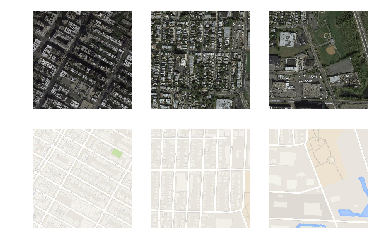

In [0]:
n_samples=3
# plot source images
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
# plot target images
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+ n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
plt.show()

## MODEL

In [0]:
from keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Dropout, Concatenate
from keras.initializers import RandomNormal

### Discriminator

In [0]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512 (2)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(1, (4,4), padding='same', kernel_inittializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weight=[0.5])
    
    return model

In [0]:
def define_encoder_block(layer_ing, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_layers, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

def define_generator(image_shape=(256,256,3)):
    init = RandomNorma(stddev=0.02)
    in_image = Input(shape=image_shape)
    # encoder
    e1 = define_encoder_block(in_image, 64, batchnorm=True)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder
    d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    output_image=Activation('tanh')(g)
    model=Model(in_image, out_image)
    
    return model
    

In [0]:
def define_gan(g_model, d_model, image_shape):
    d_model.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weight=[1, 100])
    return model

In [0]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0']. data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [0]:
def generate_real_samples(dataset, n_samples, path_shape):
    trainA, trainB = dataset
    idx = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[idx], trainB[idx]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [0]:
def sumarize_performance(step, g_model, dataset, n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    
    X_realA = (X_realA + 1 )  / 2.0
    X_realB = (X_realB + 1 )  / 2.0
    X_fakeB = (X_fakeB + 1 )  / 2.0
    
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
	# plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
	# plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
	# save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [0]:
def train(d_model, g_model, gan_model, dataset, n_epoches=10, n_batch=1):
    